In [19]:
import pandas as pd
from sklearn.model_selection import GridSearchCV
import numpy as np
import lime
from lime.lime_tabular import LimeTabularExplainer

In [9]:
# chargement des données d'entrainement

scoring = pd.read_csv('scoring.csv')

In [10]:
# données d'entrainement

scoring.head()

,SK_ID_CURR,TARGET,DAYS_BIRTH,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,DAYS_EMPLOYED,REGION_POPULATION_RELATIVE,FLAG_EMAIL,HOUR_APPR_PROCESS_START,FLAG_DOCUMENT_6,...,weekday_process_SATURDAY,type_suite_Family,flag_realty_Y,flag_car_Y,anciennete_pro/age,credit/revenu,credit/revenu/age,EXT_SOURCE_2/credit,EXT_SOURCE_2/age,nb_enf/age
0,185156,0,9.077609,793,0.000000,-1466,-4.604570,0,15,0,...,0,1,1,0,-161.496277,0.000141,0.000015,-0.029605,-0.041290,0.000000
1,335180,0,9.739202,513,6.113682,-415,-3.971242,1,18,0,...,0,0,1,0,-42.611292,0.000059,0.000006,-0.037636,-0.051491,0.102678
2,177722,0,9.567805,4917,6.423247,-854,-2.624058,0,15,0,...,0,0,0,1,-89.257672,0.000034,0.000004,-0.053378,-0.072621,0.000000
3,217168,0,9.573733,2069,0.000000,-439,-3.682341,0,15,0,...,0,0,1,0,-45.854633,0.000060,0.000006,-0.033719,-0.047439,0.000000
4,384513,0,9.265302,2528,6.184149,-300,-4.958992,0,15,0,...,0,0,0,0,-32.378869,0.000066,0.000007,-0.021546,-0.030857,0.000000


In [90]:
from sklearn.model_selection import train_test_split

X = scoring.iloc[:,2:66] # je ne prends pas TARGET, ni l'ID
y = scoring.TARGET 

# Séparation des données test et d'entrainement

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [91]:
# Standardisation des données

from sklearn import preprocessing

std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)

In [14]:
from sklearn.ensemble import AdaBoostClassifier

parameters = {'algorithm': ['SAMME', 'SAMME.R'],
              'n_estimators': [5, 20, 50, 100, 500]} # voir à augmenter le nombre d'estimateurs (5000)

adab = GridSearchCV(AdaBoostClassifier(), parameters, cv = 5, n_jobs = 5)
adab.fit(X_train_std, y_train)

GridSearchCV(cv=5, estimator=AdaBoostClassifier(), n_jobs=5,
             param_grid={'algorithm': ['SAMME', 'SAMME.R'],
                         'n_estimators': [5, 20, 50, 100, 500]})

In [17]:
X_featurenames = X.columns

In [38]:
# https://medium.com/analytics-vidhya/explain-your-model-with-lime-5a1a5867b423

In [25]:
# modèle Lime pour les feature importances

explainer = lime.lime_tabular.LimeTabularExplainer(np.array(X_train_std),
                    feature_names = X_featurenames, 
                    class_names=['TARGET'],                             
                    verbose=True, mode='regression')

## j'aurais aimé mettre "mode = classification" mais dans la cellule du dessous ça renvoie que Lime ne peut pas faire de classification avec des probabilités.

Intercept 0.6247483873295012
Prediction_local [-0.22614596]
Right: 0


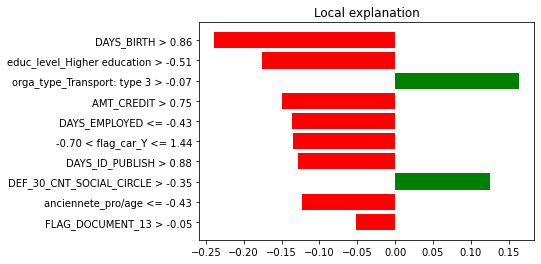

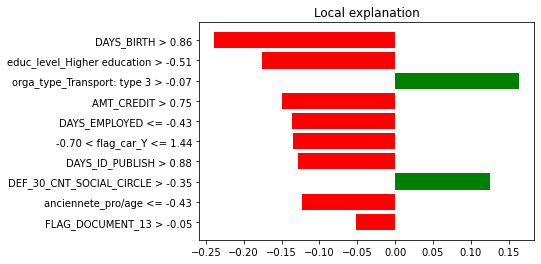

In [37]:
exp = explainer.explain_instance(X_test.iloc[0], adab.predict)
exp.as_pyplot_figure()

## Pour ce client, les 10 variables les plus influentes sur la décision sont celles du graphique:
### âge > 0.86 est très inversement corrélé à la décision
### niveau d'éducation scolaire > -0.51 est inversement corrélé à la décision
### type de transport > -0.07 est positivement corrélé à la décision
# ...

### Essai sur un autre client:

Intercept 0.6100923219973033
Prediction_local [-0.31958433]
Right: 0


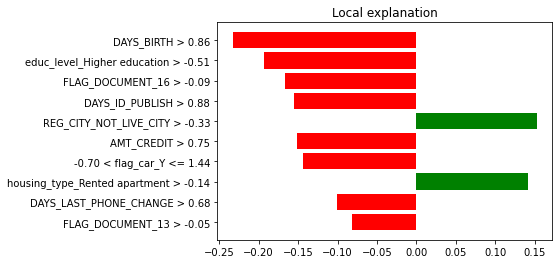

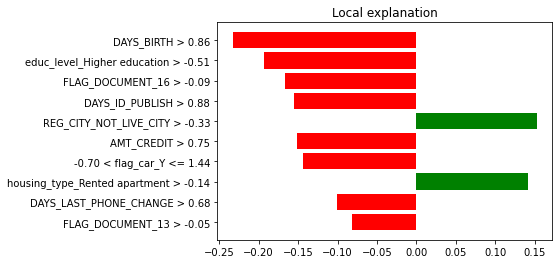

In [30]:
exp = explainer.explain_instance(X_test.iloc[1], adab.predict)
exp.as_pyplot_figure()

In [27]:
pd.DataFrame(exp.as_list())

,0,1
0,orga_type_Transport: type 3 > -0.07,0.299195
1,DAYS_BIRTH > 0.86,-0.224049
2,educ_level_Higher education > -0.51,-0.164960
3,DAYS_EMPLOYED <= -0.43,-0.156409
4,DAYS_LAST_PHONE_CHANGE > 0.68,-0.139887
5,AMT_CREDIT > 0.75,-0.134943
6,anciennete_pro/age <= -0.43,-0.125202
7,-0.70 < flag_car_Y <= 1.44,-0.116764
8,DEF_30_CNT_SOCIAL_CIRCLE > -0.35,0.111206
9,DAYS_ID_PUBLISH > 0.88,-0.106732


### J'applique ce modèle de feature importances sur l'échantillon test

In [75]:
df_dash = pd.read_csv('df_dash.csv')

In [82]:
df = df_dash.drop(['adaboost_proba'], axis = 1)
df.head()

,SK_ID_CURR,adaboost_result,DAYS_BIRTH,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,DAYS_EMPLOYED,REGION_POPULATION_RELATIVE,FLAG_EMAIL,HOUR_APPR_PROCESS_START,FLAG_DOCUMENT_6,...,weekday_process_SATURDAY,type_suite_Family,flag_realty_Y,flag_car_Y,anciennete_pro/age,credit/revenu,credit/revenu/age,EXT_SOURCE_2/credit,EXT_SOURCE_2/age,nb_enf/age
0,100001,0,-19241,-812,-1740.0,-2329,0.018850,1,18,0,...,0,0,1,0,0.121044,4.213333,-0.000219,1.388281e-06,-0.000041,-0.000000
1,100005,0,-18064,-1623,0.0,-4469,0.035792,0,9,0,...,0,0,1,0,0.247398,2.250182,-0.000125,1.309234e-06,-0.000016,-0.000000
2,100013,0,-20038,-3503,-856.0,-4458,0.019101,0,14,0,...,0,0,1,1,0.222477,3.275378,-0.000163,1.055065e-06,-0.000035,-0.000000
3,100028,0,-13976,-4208,-1805.0,-1866,0.026392,0,11,0,...,0,0,1,0,0.133515,5.000000,-0.000358,3.236045e-07,-0.000036,-0.000143
4,100038,0,-13040,-4262,-821.0,-2191,0.010032,0,5,0,...,0,0,0,1,0.168021,3.475000,-0.000266,6.805552e-07,-0.000033,-0.000077


## Est-ce que je dois normaliser les données pour le test ? Les features retenues ne sont plus du tout les mêmes que sur le train si je ne standardise pas. Mais quand je standardise, le modèle Lime ne fonctionne plus.

In [104]:
X = df.iloc[:,2:66] # je ne prends pas l'ID
X_featurenames = X.columns

In [97]:
#std_scale = preprocessing.StandardScaler().fit(X)
#X = std_scale.transform(X)

In [105]:
explainer = lime.lime_tabular.LimeTabularExplainer(np.array(X),
                    feature_names = X_featurenames, 
                    class_names=['adaboost_result'],                             
                    verbose=True, mode='regression')

Intercept 0.14688871192064012
Prediction_local [-0.04533125]
Right: 0


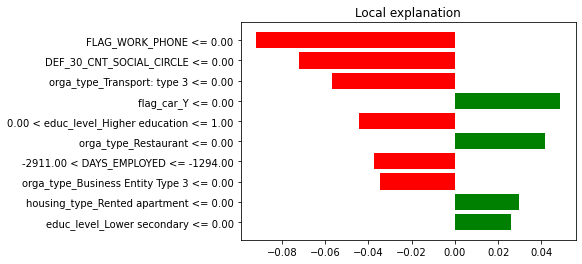

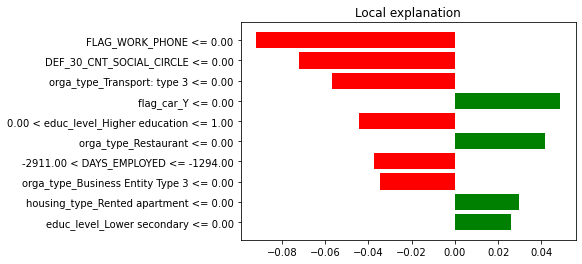

In [103]:
exp = explainer.explain_instance(X.iloc[0], adab.predict)
exp.as_pyplot_figure()

### Je teste sur un 2e client

Intercept 0.10296534525037138
Prediction_local [-0.00307687]
Right: 0


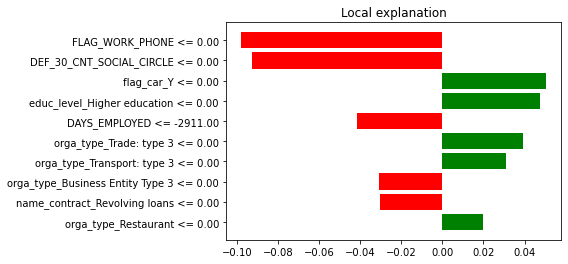

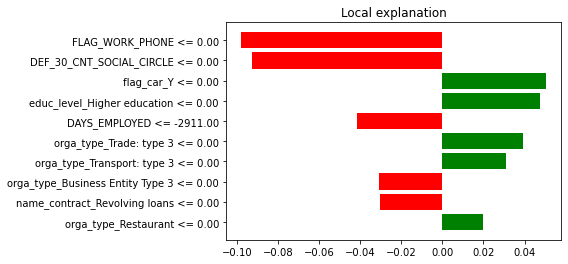

In [107]:
exp = explainer.explain_instance(X.iloc[1], adab.predict)
exp.as_pyplot_figure()

In [108]:
df.shape

(48707, 66)